# Exercises Week 9 in 02506: Developing a Neural Network for MNIST 

The dataset can be downloaded [as .gz files here](http://yann.lecun.com/exdb/mnist/).

<p align="center"> 
  <img src="../MNIST/raw/MNIST_images_train/image_train_00000.png" width="300" title="Very simple NN">
</p>

### Imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import cv2
from skimage.io import imshow
import random
import torch

# import data handler
from datahandler import *

# for transformations
import torchvision.transforms as transforms

# Importing UNet
from UNet import *

### Defining on Load Transformations

In [7]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

img_trans = transforms.Compose([transforms.ToPILImage(),
                                transforms.RandomCrop(128,20),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.RandomRotation(degrees = 45),
                                transforms.ToTensor(),
                                transforms.Normalize((0),(1)),
                                AddGaussianNoise(std=0.05)
                                ])

lab_trans = transforms.Compose([transforms.ToPILImage(),
                                transforms.RandomCrop(128,20),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.RandomRotation(degrees = 45),
                                transforms.ToTensor()
                                ])

### Pre-processing of Data

torch.Size([10, 1, 128, 128])
torch.Size([10, 1, 128, 128])


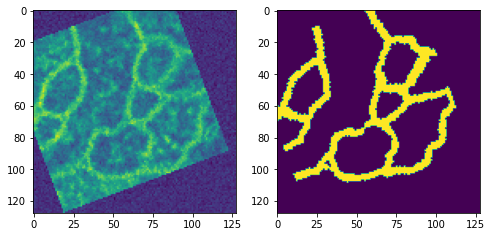

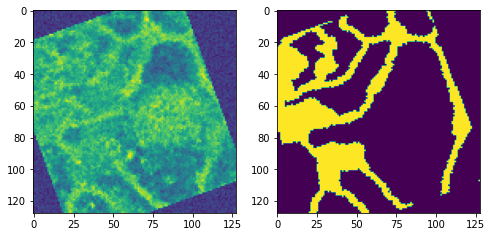

In [8]:
data_dir=r'./'
subset='train'
im_id=range(1,31)    
TrainData = DataHandler(
    data_dir, 
    im_id, 
    subset,
    is_ubuntu=True,
    img_trans=img_trans,
    lab_trans=lab_trans)

a,b=TrainData.__getitem__(2)

# Define dataloader 
train_loader = DataLoader(dataset = TrainData, 
                                           batch_size = 10,
                                           shuffle = False,
                                           num_workers = 0)

pbar = enumerate(train_loader)
train_loss = []
for i, (images,target) in pbar:
    print(images.shape)
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,10))
    ax1.imshow(images.numpy()[0][0])
    ax2.imshow(target.numpy()[0][0])
    break
for i, (images,target) in pbar:
    print(images.shape)
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,10))
    ax1.imshow(images.numpy()[0][0])
    ax2.imshow(target.numpy()[0][0])
    break

### Defining Loss and Optimizer

In [9]:
#%% parameters
lr = 0.00006

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using cuda')
else:
    device = torch.device('cpu')
    print('Using cpu')


model = UNet()

loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


#%%
train_loader = DataLoader(dataset = TrainData, 
                                           batch_size = 10,
                                           shuffle = True,
                                           num_workers = 0)



Using cpu


### Defining Accuracy

In [10]:
def accuracy(y,t):
    y = np.round(y.detach().numpy())
    t = np.round(t.detach().numpy())
    B,M,N = np.shape(y)
    return  np.sum(y.flatten() == t.flatten())/(B*M*N)

### Training  the network

In [11]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

epochs = 40

N_train = len(train_loader)
N_test = 0
print(f"There are {N_train} training and {N_test} test batches")
for e in range(epochs):
    train_l = 0
    train_a = 0
    model.train()
    for i,tmp in enumerate(train_loader):
        x,t = tmp
        optimizer.zero_grad()
        y = model.forward(x)
        t = torch.round(t)
        #print(y[:,1,:,:].shape)
        #print(y[0,:,0,0])
        #print(t[:,0,:,:].shape)
        loss = loss_function(y[:,1,:,:],t[:,0,:,:])
        train_l += loss.item()
        loss.backward()
        optimizer.step()
        train_a += accuracy(y[:,1,:,:],t[:,0,:,:])
    train_loss.append(train_l/N_train)
    train_acc.append(train_a/N_train)
    model.eval()
    print(f"Finished epoch {e+1} of {epochs}. The loss is {train_l/N_train} and the accuracy is {train_a/N_train}")

There are 48 training and 0 test batches
Finished epoch 1 of 40. The loss is 0.7203236222267151 and the accuracy is 0.17253265380859373
Finished epoch 2 of 40. The loss is 0.7151585407555103 and the accuracy is 0.17155316670735676
Finished epoch 3 of 40. The loss is 0.7084462270140648 and the accuracy is 0.17143376668294272
Finished epoch 4 of 40. The loss is 0.6930047087371349 and the accuracy is 0.4274632771809896
Finished epoch 5 of 40. The loss is 0.5548684330036243 and the accuracy is 0.8273197174072267
Finished epoch 6 of 40. The loss is 0.4837977370868127 and the accuracy is 0.8297126770019534
Finished epoch 7 of 40. The loss is 0.46725978578130406 and the accuracy is 0.8281580607096352
Finished epoch 8 of 40. The loss is 0.4493408836424351 and the accuracy is 0.826824442545573
Finished epoch 9 of 40. The loss is 0.41844491598506767 and the accuracy is 0.8275365193684895
Finished epoch 10 of 40. The loss is 0.38979844686885673 and the accuracy is 0.8279827117919923
Finished epoc

### Evaluating the Network

<bound method Figure.show of <Figure size 864x288 with 2 Axes>>

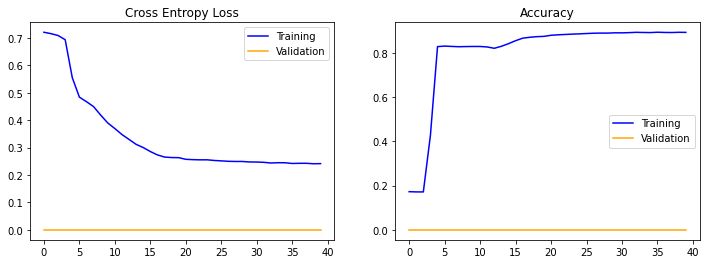

In [12]:
val_loss = 0*np.array(train_loss)
val_acc = 0*np.array(train_acc)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(range(0,epochs),train_loss,c = 'blue',label='Training')
ax1.plot(range(0,epochs),val_loss,c = 'orange',label='Validation')
ax1.legend()
ax1.set_title("Cross Entropy Loss")
ax2.plot(range(0,epochs),train_acc,c = 'blue',label='Training')
ax2.plot(range(0,epochs),val_acc,c = 'orange',label='Validation')
ax2.legend()
ax2.set_title("Accuracy")
fig.show

### Some examples of the Classification

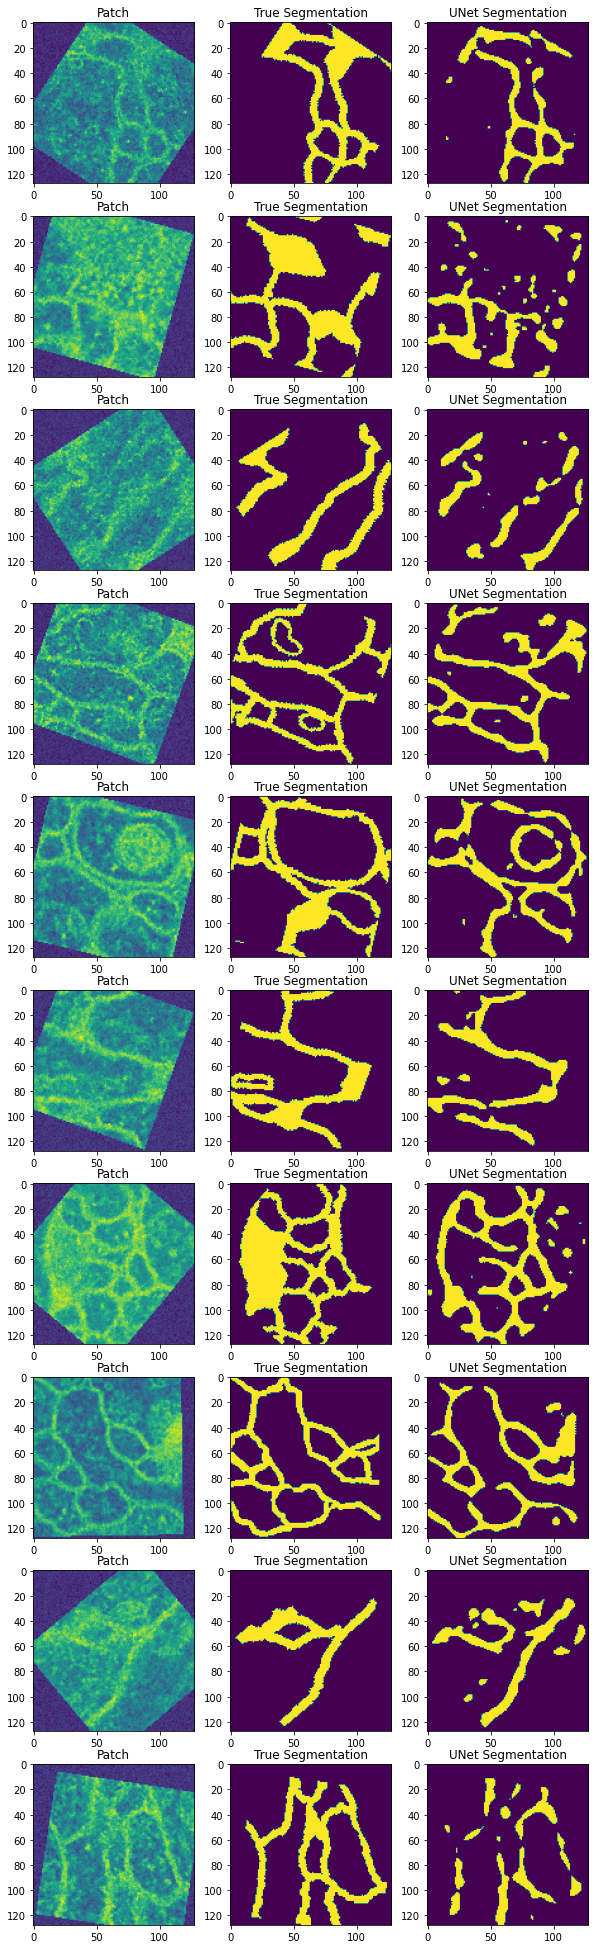

In [13]:
for i,tmp in enumerate(train_loader):
    x,t = tmp
    y = model.forward(x)
    t = torch.round(t)
    m = x.shape[0]
    n = 3

    fig, ax = plt.subplots(m,n,figsize=(10,3.5*m))

    for i in range(m):
        ax[i][0].imshow(x[i,0,:,:].detach().numpy())
        ax[i][0].set_title("Patch")
        ax[i][1].imshow(np.round(t[i,0,:,:].detach().numpy()))
        ax[i][1].set_title("True Segmentation")
        ax[i][2].imshow(np.round(y[i,1,:,:].detach().numpy()))
        ax[i][2].set_title("UNet Segmentation")

    break